In [1]:
!mkdir data

In [2]:
%%capture
!pip install gdown
!cd data && gdown "10nb-yVKttNsZ-UUqlFxxZ8pZfZo2Bjkz" && gdown "19gqhWlyEKo2d_j3dk7Hxz4LX0M6do0s_"

In [3]:
%%capture
!pip install -q peft transformers datasets evaluate seqeval accelerate bitsandbytes trl

In [4]:
from tokenizers import BertWordPieceTokenizer, ByteLevelBPETokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification, AutoTokenizer
from transformers import pipeline
from peft import IA3Config, TaskType, get_peft_model, LoraConfig
import json
import random
import pandas as pd
import numpy as np
import evaluate
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import os
import warnings

warnings.filterwarnings('ignore')

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [5]:
model_name =  'ai-forever/ruRoberta-large'
wp_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
NERS = ['AGE', 'AWARD', 'CITY', 'COUNTRY', 'CRIME', 'DATE', 'DISEASE', 'DISTRICT', 'EVENT', 'FACILITY', 'FAMILY', 
        'IDEOLOGY', 'LANGUAGE', 'LAW', 'LOCATION', 'MONEY', 'NATIONALITY', 'NUMBER', 'ORDINAL', 'ORGANIZATION', 
        'PENALTY', 'PERCENT', 'PERSON', 'PRODUCT', 'PROFESSION', 'RELIGION', 'STATE_OR_PROVINCE', 'TIME', 'WORK_OF_ART'
]

## Look at the data more closely

In [7]:
data = pd.read_json('data/train.jsonl', lines=True)

In [8]:
data.sample(3)

,ners,sentences,id
421,"[[0, 6, FACILITY], [23, 37, FACILITY], [39, 53...",Биг-Бен переименован в Башню Елизаветы\nБашня ...,421
107,"[[7, 13, PROFESSION], [15, 25, PERSON], [28, 3...",Умерла актриса Кэрри Фишер\n\nКэрри Фишер\n27 ...,107
310,"[[2, 7, COUNTRY], [32, 41, PROFESSION], [43, 5...",В Польше найден мёртвым сын экс-президента Лех...,310


Depth is same is level of nestedness: for tags list [[0, 100, FACILITY], [0, 10, PERSON]] the first tag has depth 0, and the second has depth 1.

In the modeling below I assume that if two tags intersect then one is nested inside another.

In [9]:
depths = []
num_same_nested = 0

for ners in data.ners:
    # scan-line assuming begin is earlier than end
    events = [(begin, -1, tag) for begin, _, tag in ners] + [(end, +1, tag) for _, end, tag in ners]
    events.sort()
    max_depth = 0
    current_depth = 0
    outer_tags = {tag: 0 for tag in set([e[-1] for e in events])}
    for t, ev_type, tag in events:
        current_depth -= ev_type
        max_depth = max(max_depth, current_depth)
        if outer_tags[tag] != 0:
            num_same_nested += 1
        if ev_type == -1:
            outer_tags[tag] += 1
        else:
            outer_tags[tag] -= 1
            
    depths.append(max_depth)

Text(0.5, 1.0, 'Max depth per sentence')

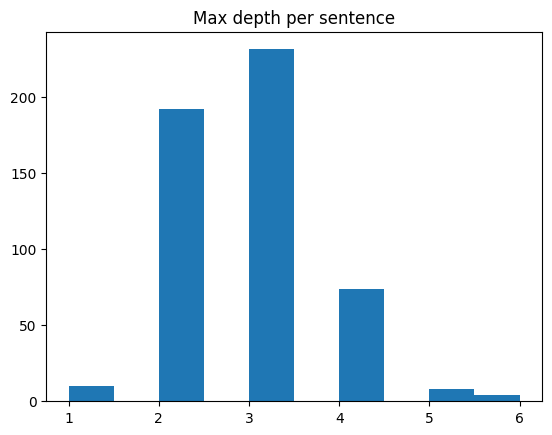

In [10]:
import matplotlib.pyplot as plt

plt.hist(depths);
plt.title('Max depth per sentence')

## Adapted dataset

In [11]:
# Code adapted from https://github.com/dialogue-evaluation/RuNNE/blob/main/baseline/iobes_flat_dataset.py
class IOBESFlatRuNNEDataset(Dataset):

    def __init__(self, dataset, tokenizer, max_length, depth):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.all_data = dataset

        flat_data = []
        # select only those entities which are at depth level 'depth'
        for c in self.all_data:
            flats = []
            for ec in c["entities"]:
                start = ec["start"]
                end = ec["end"]
                # Depth for entity E is equal to the number of entities E' inside which E is nested
                if len([e for e in c["entities"] if e["start"] <= start and e["end"] > end or e["start"] < start and e["end"] >= end]) == depth:
                    flats.append(ec)
            flat_data.append({**c, "entities" : flats})
        self.flat_data = flat_data

        new_data = []
        # Convert entites bound to token-wise labels
        for c in self.flat_data:
            context = c["context"]
            encodings = self.tokenizer.encode_plus(context, return_token_type_ids=True, return_special_tokens_mask=True, return_offsets_mapping=True)
            tokens = encodings['input_ids']
            offsets = encodings['offset_mapping']
            attention_mask = encodings['attention_mask']

            origin_offset2token_idx_start = {}
            origin_offset2token_idx_end = {}
            for token_idx in range(len(tokens)):
                token_start, token_end = offsets[token_idx]
                # skip [CLS] or [SEP]
                if token_start == token_end == 0:
                    continue

                token_end -= 1
                origin_offset2token_idx_start[token_start] = token_idx
                origin_offset2token_idx_end[token_end] = token_idx
            
            valid_entities = []
            # Convert char indices for entities into token indices
            for e in c["entities"]:
                start = e["start"]
                end = e["end"]
                try:
                    new_start = origin_offset2token_idx_start[start]
                    new_end = origin_offset2token_idx_end[end]
                except KeyError:
                    pass

                valid_entities.append({
                        **e,
                        "tl_start" : new_start,
                        "tl_end" : new_end
                    })
            new_data.append({
                    **c,
                    "entities" : valid_entities,
                    "tokens" : tokens,
                    "attention_mask" : attention_mask,
                    "offsets" : offsets,
                })

        self.flat_data = new_data

        labeled_data = []
        # IOBES labeling
        for c in self.flat_data:
            labels = []
            for e in c["entities"]:
                labels.append((e["tag"], e["tl_start"], e["tl_end"]))
            label_seq = ["O"] * len(c["tokens"])

            for tag, start, end in labels:
                if start == end: # S
                    label_seq[start] = 'S-' + tag
                else: # BI*E
                    label_seq[start] = 'B-' + tag 
                    label_seq[end] = 'E-' + tag 
                    for i in range(start + 1, end):
                        label_seq[i] = 'I-' + tag

            labeled_data.append({
                    **c,
                    "labels" : label_seq
                })

        self.data = labeled_data

        tags = [t.strip() for t in NERS]

        tag_to_id = {}
        # IOBES labeling
        for idx, tag in enumerate(tags):
            tag_to_id['B-' + tag] = idx * 4 + 1
            tag_to_id['I-' + tag] = idx * 4 + 2
            tag_to_id['E-' + tag] = idx * 4 + 3
            tag_to_id['S-' + tag] = idx * 4 + 4
        tag_to_id['O'] = 0

        self.tag_to_id = tag_to_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        data = self.data[item]

        assert len(data["tokens"]) == len(data["attention_mask"])
        assert len(data["attention_mask"]) == len(data["labels"])

        labels_ids = [self.tag_to_id[tag] for tag in data["labels"]]

        tokens = data["tokens"]
        attention_mask = data["attention_mask"]
        offsets = data["offsets"]

        # truncate to max_len tokens
        tokens = tokens[: self.max_length]
        attention_mask = attention_mask[: self.max_length]
        labels_ids = labels_ids[: self.max_length]
        offsets = offsets[: self.max_length]

        sep_token = self.tokenizer.sep_token_id
        if tokens[-1] != sep_token:
            assert len(tokens) == self.max_length
            tokens = tokens[: -1] + [sep_token]

        return {'input_ids': torch.LongTensor(tokens),
                'attention_mask': torch.LongTensor(attention_mask),
                'labels': torch.LongTensor(labels_ids)}

## Add more data

I joined the train dataframe given on CodaLab with the train subpart of the dataset https://huggingface.co/datasets/iluvvatar/RuNNE mentioned in the useful links in CodaLab

In [ ]:
train_data = pd.read_json('data/train.jsonl', lines=True).drop(["id"], axis=1)
runne_dataset = load_dataset("iluvvatar/RuNNE", trust_remote_code=True)['train'].to_pandas().drop(['id'], axis=1)
runne_dataset['entities'] = runne_dataset['entities'].apply(lambda x: [[int(ent.split()[0]),
                                                                        int(ent.split()[1]) - 1,
                                                                        ent.split()[2]] for ent in x])
train_data = pd.concat([runne_dataset.rename(columns={'text': 'sentences', 'entities': 'ners'}),
                        train_data], ignore_index=True)
train_data = train_data.drop_duplicates(subset='sentences')
train_data, val_data = train_test_split(train_data, train_size=0.8, random_state=0)

# List of dict{'entities': {'tag', 'start', 'end'}, 'context'}
train_dataset = []
for ners, sentence in zip(train_data.ners, train_data.sentences):
    train_dataset.append({
        'entities': [{'tag': x[2], 'start': x[0], 'end': x[1]} for x in ners],
        'context': sentence
    })

val_dataset = []
for ners, sentence in zip(val_data.ners, val_data.sentences):
    val_dataset.append({
        'entities': [{'tag': x[2], 'start': x[0], 'end': x[1]} for x in ners],
        'context': sentence
    })

In [13]:
data_collator = DataCollatorForTokenClassification(wp_tokenizer)

In [14]:
seqeval = evaluate.load("seqeval")

In [15]:
test_set = pd.read_json('data/test.jsonl', lines=True)

In [16]:
import os

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api")

os.environ['WANDB_API_KEY'] = wandb_api

## Train loop for depths

In [17]:
from functools import partial

def compute_metrics(p, label_list):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [18]:
def create_datasets(depth):
    # Only the entities at depth level 'depth' will be added to labels, other will be masked as 'O'
    flat_train_dataset = IOBESFlatRuNNEDataset(dataset = train_dataset, 
                                         tokenizer = wp_tokenizer,
                                         max_length = 512, depth=depth)
    
    flat_val_dataset = IOBESFlatRuNNEDataset(dataset = val_dataset, 
                                         tokenizer = wp_tokenizer,
                                         max_length = 512, depth=depth)
    label_list = list(flat_train_dataset.tag_to_id.items())
    label_list.sort(key=lambda x: x[1])
    label_list = [label[0] for label in label_list]
    
    label2id = flat_train_dataset.tag_to_id
    id2label = {i: label for label, i in label2id.items()}

    return flat_train_dataset, flat_val_dataset, label_list, label2id, id2label

def train_on_depth(depth):
    # Fit the model for NER of entities which are at the given depth
    flat_train_dataset, flat_val_dataset, label_list, label2id, id2label = create_datasets(depth)
    model = AutoModelForTokenClassification.from_pretrained(
        model_name, num_labels=29 * 4 + 1, id2label=id2label, label2id=label2id
    )
    peft_config = LoraConfig(task_type=TaskType.TOKEN_CLS, r=8)
    model = get_peft_model(model, peft_config)
    training_args = TrainingArguments(
        output_dir=f"checkpoints_depth_{depth}",
        learning_rate=0.001,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        gradient_accumulation_steps=4,
        num_train_epochs=20,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit=2,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=flat_train_dataset,
        eval_dataset=flat_val_dataset,
        tokenizer=wp_tokenizer,
        data_collator=data_collator,
        compute_metrics=partial(compute_metrics, label_list=label_list),
    )
    trainer.train()
    classifier = pipeline("ner", model=model.merge_and_unload(), tokenizer=wp_tokenizer)
    return classifier


def predict(classifier, depth_level):
    # Run the token classification pipeline and retun a list in which each element is list of 
    #  NERs for the ith test set sentence in the format list[(start, end, tag, confidence, depth)]
    results = []
    aggregation_strategy = 'average'
    
    for sent in tqdm(test_set.senences):
        try:
            tags = classifier(sent, aggregation_strategy=aggregation_strategy)
            tags = [(tag['start'], tag['end'] - 1, tag['entity_group'], tag['score'], depth_level) for tag in tags]
        except RuntimeError:
            subsents = sent.split('\n')
            tags = []
            offset = 0
    
            for subsent in subsents:
                if subsent == '':
                    offset += 1
                    continue
                subtags = classifier(subsent, aggregation_strategy=aggregation_strategy)
                subtags = [(tag['start'] + offset, tag['end'] + offset - 1, tag['entity_group'], tag['score'], depth_level) for tag in subtags]
                tags.extend(subtags)
                offset += len(subsent) + 1
    
        tags.sort()
        new_tags = []
        for tag in tags:
            if len(new_tags) != 0 and tag[0] - new_tags[-1][1] <= 2 and new_tags[-1][2] == tag[2]:
                new_tags[-1] = (new_tags[-1][0], tag[1], tag[2], (tag[3] + new_tags[-1][3]) / 2, depth_level)
            else:
                new_tags.append(tag)
        tags = new_tags
    
        results.append(tags)
    return results

In [19]:
depth2preds = {}

for depth in range(0, 3):
    classifier = train_on_depth(depth)
    preds = predict(classifier, depth)
    depth2preds[depth] = preds

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: k-galliamov. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240427_201800-fsqmioml
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run solar-sun-53
wandb: ⭐️ View project at https://wandb.ai/k-galliamov/huggingface
wandb: 🚀 View run at https://wandb.ai/k-galliamov/huggingface/runs/fsqmioml


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.203781,0.251832,0.224953,0.237635,0.716957
2,No log,0.590885,0.498482,0.635987,0.558901,0.845843
3,No log,0.447151,0.585873,0.719076,0.645676,0.880339
4,No log,0.385652,0.651550,0.746594,0.695842,0.894960
5,No log,0.362938,0.664766,0.763158,0.710572,0.901495
6,No log,0.343935,0.695554,0.781592,0.736067,0.906910
7,No log,0.329418,0.720288,0.787737,0.752504,0.910304
8,No log,0.319115,0.706325,0.802565,0.751376,0.911766
9,No log,0.313907,0.717348,0.809244,0.760530,0.913174
10,No log,0.307126,0.726340,0.803767,0.763094,0.914871


  0%|          | 0/65 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.420428,0.000000,0.000000,0.000000,0.926784
2,No log,0.281540,0.286600,0.210946,0.243021,0.933770
3,No log,0.215680,0.356692,0.354048,0.355365,0.940955
4,No log,0.184476,0.385835,0.416192,0.400439,0.945810
5,No log,0.260326,0.383209,0.262828,0.311803,0.942543
6,No log,0.170601,0.405268,0.456100,0.429185,0.948915
7,No log,0.160946,0.431216,0.491448,0.459366,0.950829
8,No log,0.152838,0.451392,0.526796,0.486188,0.953139
9,No log,0.144544,0.482687,0.532497,0.506370,0.955919
10,No log,0.140049,0.505094,0.537058,0.520586,0.956966


  0%|          | 0/65 [00:00<?, ?it/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.108682,0.000000,0.000000,0.000000,0.988718
2,No log,0.089666,0.000000,0.000000,0.000000,0.988718
3,No log,0.074180,0.000000,0.000000,0.000000,0.988718
4,No log,0.063733,0.168675,0.049123,0.076087,0.988285
5,No log,0.055084,0.173913,0.042105,0.067797,0.988700
6,No log,0.051265,0.168000,0.073684,0.102439,0.988592
7,No log,0.048030,0.195767,0.129825,0.156118,0.988899
8,No log,0.050766,0.206107,0.189474,0.197441,0.988808
9,No log,0.045480,0.208955,0.147368,0.172840,0.989079
10,No log,0.042471,0.217593,0.164912,0.187625,0.989386


  0%|          | 0/65 [00:00<?, ?it/s]

In [20]:
!rm -rf data
!rm -rf wandb

## Save all predictions to file

In [21]:
depth2preds = {k: [[(y[0], y[1], y[2], str(y[3]), y[4]) for y in x] for x in v] for k, v in depth2preds.items()}

In [22]:
output_file = "raw_test.jsonl"

if os.path.exists(output_file):
    os.remove(output_file)

with open(output_file, 'w') as fp:
    json.dump(depth2preds, fp)